In [144]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob, os
import matplotlib.ticker as ticker
import argparse
import datetime
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.patches import Circle, Wedge
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.lines as mlines
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy

from matplotlib.patches import Circle, Wedge


In [145]:
#data from movie_params.py

#For Anna Lea : you have to change the first lines with the path on your system

dir_profile = "/media/ludo/DATA/google-drive/Thèse/EUREC4a/github/Input/"
path_to_sonde_profiles = os.path.join(dir_profile,"all_sondes_2.nc")

path_satellite = "/media/ludo/DATA/google-drive/Thèse/EUREC4a/github/EUREC4A_movies/satellite_data/GOES16"

# HALO circle
lon_center, lat_center = -57.717,13.3
lon_pt_circle, lat_pt_circle = -57.245,14.1903
r_circle = np.sqrt((lon_pt_circle-lon_center)**2+(lat_pt_circle-lat_center)**2)

#BCO

dt_fade = 25

# Image box
lonmin,lonmax = -60.000001,-54.999999
dlon = lonmin-lonmax
latmin,latmax = 11.5,15.000001
dlat = latmin-latmax

width = 1125
height = int(width*dlat/dlon)

dpi = 150
asp_ratio = dlat/dlon
w_inches = 10
h_inches = w_inches*asp_ratio

#For the radiance to reflectance conversion
Esun_Ch_02 = 663.274497
d2 = 0.3



In [146]:
def get_files(date, times, channel):
    
    list_files=[]
    str_channel="{0:0=2d}".format(channel)
    path_dir = os.path.join(path_satellite, str(date), "channel"+str_channel)
    for time in times:
        name = "GOES16_02_11.5N-15N_-60E--55E_20200124_"+str(time)+".nc"
        path_file = os.path.join(path_dir,name)
        list_files.append(path_file)
    return list_files

In [147]:
def loadSondes(dtime):
    """Load sondes for the day as a list of xarrays"""
    
    
    allsondes = xr.open_dataset(path_to_sonde_profiles)
                                   
    str_dtime = dtime.strftime('%Y%m%d')
    allsondes = allsondes.sel(launch_time = str_dtime)
    allsondes = allsondes.where(allsondes.Platform=="HALO", drop=True)
                                 
    return allsondes

In [148]:
def getMatchingSondes(allsondes,dtime,dt_fade, verbose=False):
    
    sondes = []
    
    # window for fading out sonde display
    delta_fade = datetime.timedelta(minutes=dt_fade)
   
    number_sondes = len(allsondes.launch_time)
    
    for i in range(number_sondes):
        sonde = allsondes.isel(launch_time=i)
        
        launch_time = datetime.datetime.strptime(str(sonde.launch_time.values)[:16],
                                                '%Y-%m-%dT%H:%M')

        # If sonde currently falling or fell in the past dt_fade mn
        if launch_time <= dtime and launch_time + delta_fade > dtime:
                
            if verbose:
                print('keep ',launch_time)
                
            # Then load sonde data and store it
            sondes.append(sonde)
    
    return sondes

In [149]:
def getSondeObj(sonde):
    
    # position of sonde at current time
    lon_sonde = sonde.latitude.dropna(dim="height").values[0]
    lat_sonde = sonde.longitude.dropna(dim="height").values[0]
    
    alpha = 1
    
    fc=ec="red"
            
    return Circle((lat_sonde,lon_sonde),0.05,linewidth=2,ec=ec,fc=fc,alpha=alpha, fill=True)

In [150]:
def getLaunchTime(sonde=None):

    if sonde is None:
        return ''
    else:
        return str(sonde.launch_time.values)[11:16]

In [151]:
def make_figure_precise(date=20200124, times=[1300,1600], channel=2):
    
    lat_box_min = 13.4
    lat_box_max = 14.6
    lon_box_min = -58
    lon_box_max = -56
    
    path_files = get_files(date, times, channel)

    plt.rcParams.update({'font.size':  15})
    
    str_channel="{0:0=2d}".format(channel)
    
    fig, ax = plt.subplots(1, 2, figsize=(9, 6), subplot_kw={'projection':ccrs.PlateCarree()}, dpi=dpi)

    fig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=1, wspace=0.15, hspace=0.05)

    
    if (channel==2):
        colormap = "Greys_r"
    else:
        colormap = "Greys"
    
    i=0

    for path_file in path_files: 
        file = xr.open_dataset(path_file).isel(time=0) 
        lon=file["lon"]
        lat=file["lat"]
               
            
        gamma = 1./3
        im = ax[i].imshow((file["C"+str_channel].values*np.pi*d2/Esun_Ch_02)**(gamma), aspect="equal",\
                            extent =[lonmin,lonmax,latmin,latmax],\
                            cmap=colormap, origin="upper", transform=ccrs.PlateCarree(), vmin=0, vmax=1)
       
        ax[i].coastlines(resolution='110m', color='yellow', linewidth=1)
        ax[i].set_ylim([lat_box_min,lat_box_max])
        ax[i].set_xlim([lon_box_min,lon_box_max])

        gl = ax[i].gridlines(color='w',linestyle='-', linewidth=0.1, alpha=1, draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xlocator = ticker.MultipleLocator(0.5)
        gl.ylocator =ticker.MultipleLocator(0.5)
        if(i==1): gl.ylabels_left = False
#         if(j==1): gl.ylabels_left = False
        
        time = datetime.datetime.strptime(str(date)+str(times[i]),'%Y%m%d%H%M')
        allsondes = loadSondes(time)
        selsondes = getMatchingSondes(allsondes,time,dt_fade)
        
        circ = Circle((lon_center,lat_center),r_circle,linewidth=1,ec="white",fill=False)
        ax[i].add_patch(circ)
        
        ax[i].text(lon_box_max-1,lat_box_max-0.4,time.strftime('%Y-%m-%d\n%H:%M UTC'),
            color='white',fontsize=20)
        
        
        for sonde in selsondes:
            sonde_obj = getSondeObj(sonde)
            ax[i].add_patch(sonde_obj)
            lon_sonde,lat_sonde = sonde_obj.center
            str_launch_time = str(sonde.launch_time.values)[11:16]
            ax[i].text(lon_sonde+0.05, lat_sonde+0.05,
                         str_launch_time, color="white",
                        fontsize=12)

        color=sonde_obj.get_fc()

                
        i+=1
    
       
    fig.text(0.5, 0.36, 'Longitude', ha='center')
    fig.text(0., 0.6, 'Latitude', va='center', rotation='vertical')
                       
    x,y,w,h = ax[0].get_position().bounds
    c_map_ax = fig.add_axes([x, y-0.5*h, 2.16*w, 0.1*h])
    cbar = fig.colorbar(im,cax=c_map_ax, orientation="horizontal")
    cbar.ax.set_xlabel('Reflectance',color='k') # cbar legend
        
#     fig.savefig("../Figures/satellite_veil_clouds.jpg")
    

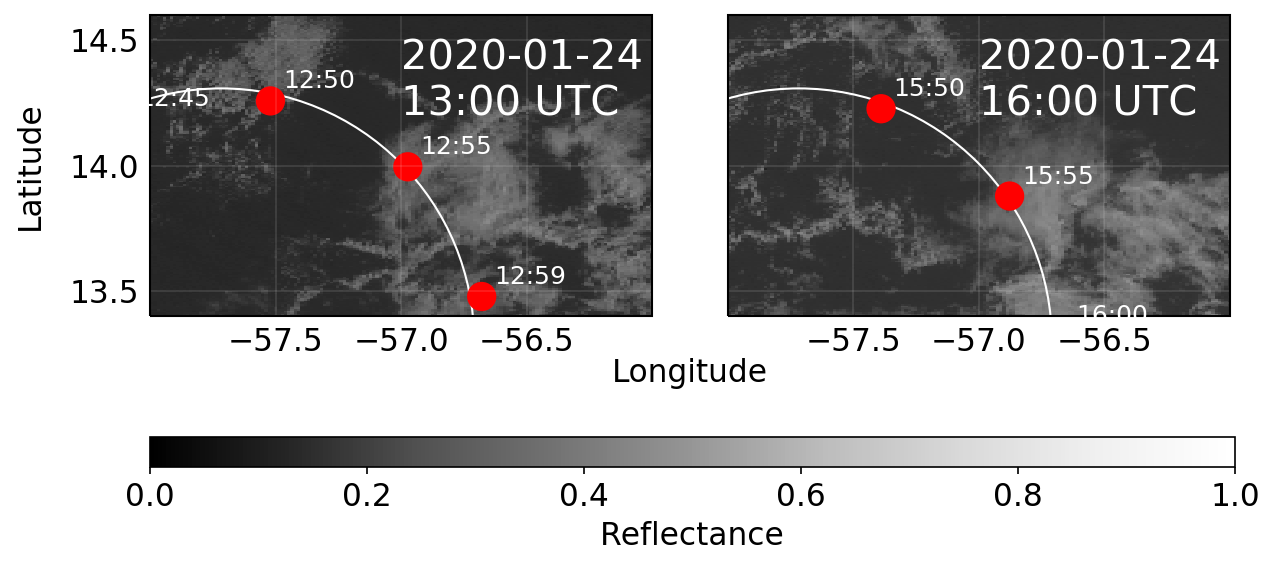

In [143]:
make_figure_precise()